In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import plotly
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train_dataset_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
test_dataset_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TEST"

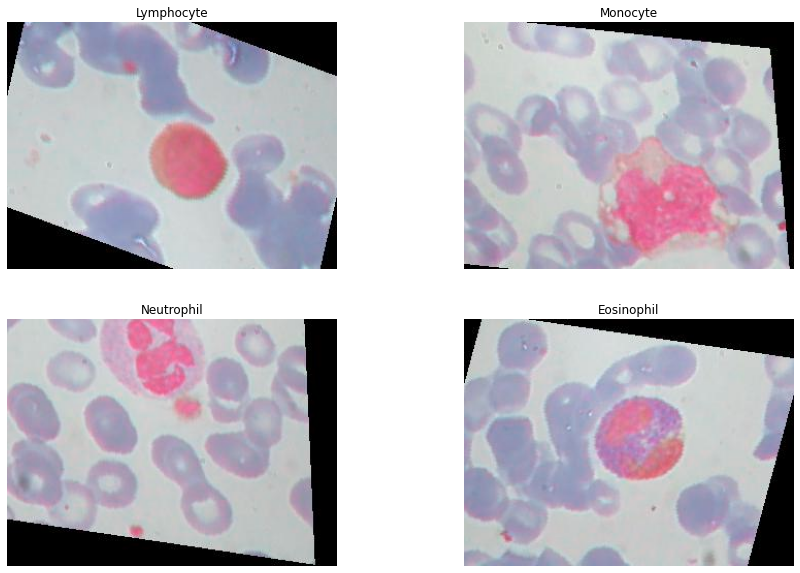

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title('Lymphocyte'); plt.axis('off'); plt.imshow(cv2.imread('../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_1063.jpeg'))
plt.subplot(222)
plt.title('Monocyte'); plt.axis('off');plt.imshow(cv2.imread('../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_1173.jpeg'))
plt.subplot(223)
plt.title('Neutrophil'); plt.axis('off'); plt.imshow(cv2.imread('../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_1095.jpeg'))
plt.subplot(224)
plt.title('Eosinophil'); plt.axis('off');plt.imshow(cv2.imread('../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_1169.jpeg'))

# ResNet50 with Imagesize (224,224,3)

In [4]:
base_model = ResNet50(include_top=False,weights="imagenet")
for layer in base_model.layers[:140]:
    layer.trainable = False

2022-11-01 03:03:17.264233: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 0s 0us/step


In [5]:
model = keras.Sequential()

model.add(layers.Input(shape=(224,224,3)))
model.add(layers.Lambda(keras.applications.resnet50.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 14,986,244
Non-trainable params: 8,609,664
_________________________________________________________________


In [6]:
testGen = ImageDataGenerator()
trainGen = ImageDataGenerator(validation_split=0.15,vertical_flip=True,horizontal_flip=True,rotation_range=0.2)
trainGenerator = trainGen.flow_from_directory(train_dataset_path,subset="training",target_size=(224,224))
validationGenerator = trainGen.flow_from_directory(train_dataset_path,subset="validation",target_size=(224,224))
testGenerator = testGen.flow_from_directory( test_dataset_path,target_size=(224,224),shuffle=False)                               

Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


## ResNet50 with 1 epoch

In [7]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=1,validation_data=validationGenerator)

2022-11-01 03:03:24.802517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


265/265 [==============================] - 815s 3s/step - loss: 0.2699 - accuracy: 0.9039 - val_loss: 0.3107 - val_accuracy: 0.9034


Test Accuracy: 79.895 %


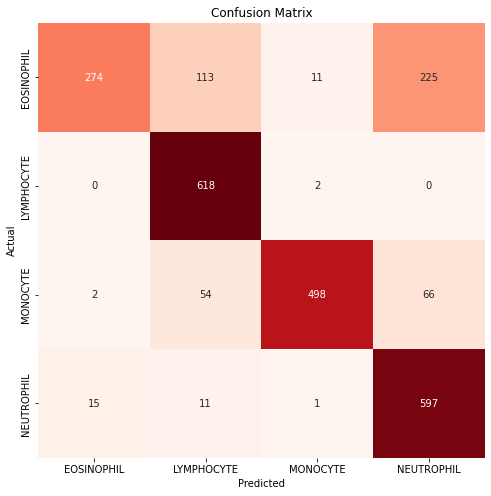

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.94      0.44      0.60       623
  LYMPHOCYTE       0.78      1.00      0.87       620
    MONOCYTE       0.97      0.80      0.88       620
  NEUTROPHIL       0.67      0.96      0.79       624

    accuracy                           0.80      2487
   macro avg       0.84      0.80      0.79      2487
weighted avg       0.84      0.80      0.79      2487



In [8]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

## ResNet50 with 2 epoch

In [9]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=2,validation_data=validationGenerator)

Epoch 1/2
265/265 [==============================] - 816s 3s/step - loss: 0.0960 - accuracy: 0.9667 - val_loss: 1.7282 - val_accuracy: 0.8833
Epoch 2/2
265/265 [==============================] - 799s 3s/step - loss: 0.0583 - accuracy: 0.9804 - val_loss: 0.0349 - val_accuracy: 0.9899


Test Accuracy: 86.771 %


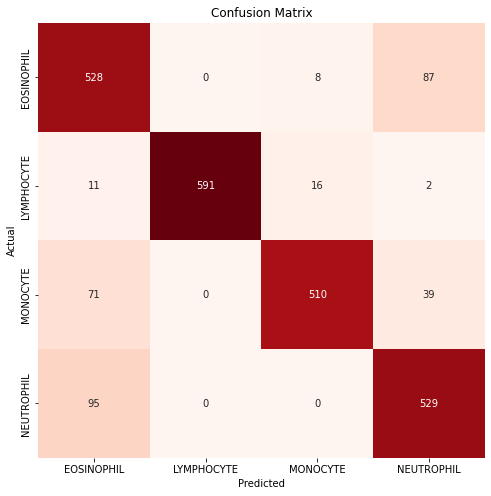

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.75      0.85      0.80       623
  LYMPHOCYTE       1.00      0.95      0.98       620
    MONOCYTE       0.96      0.82      0.88       620
  NEUTROPHIL       0.81      0.85      0.83       624

    accuracy                           0.87      2487
   macro avg       0.88      0.87      0.87      2487
weighted avg       0.88      0.87      0.87      2487



In [10]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

## ResNet50 with 3 epochs

In [11]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=3,validation_data=validationGenerator)

Epoch 1/3
265/265 [==============================] - 795s 3s/step - loss: 0.0388 - accuracy: 0.9862 - val_loss: 0.0522 - val_accuracy: 0.9859
Epoch 2/3
265/265 [==============================] - 797s 3s/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0084 - val_accuracy: 0.9960
Epoch 3/3
265/265 [==============================] - 804s 3s/step - loss: 0.0190 - accuracy: 0.9948 - val_loss: 0.0254 - val_accuracy: 0.9906


Test Accuracy: 80.378 %


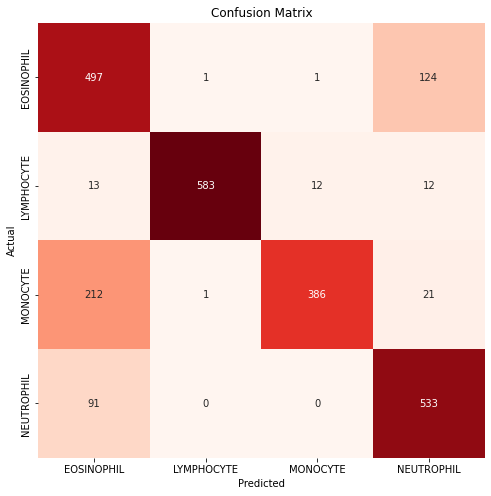

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.61      0.80      0.69       623
  LYMPHOCYTE       1.00      0.94      0.97       620
    MONOCYTE       0.97      0.62      0.76       620
  NEUTROPHIL       0.77      0.85      0.81       624

    accuracy                           0.80      2487
   macro avg       0.84      0.80      0.81      2487
weighted avg       0.84      0.80      0.81      2487



In [12]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

# ResNet50 with Imagesize(185,200,3)

In [13]:
base_model = ResNet50(include_top=False,weights="imagenet")
for layer in base_model.layers[:140]:
    layer.trainable = False

In [14]:
model = keras.Sequential()

model.add(layers.Input(shape=(185,200,3)))
model.add(layers.Lambda(keras.applications.resnet50.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 185, 200, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 14,986,244
Non-trainable params: 8,609,664
_________________________________________________________________


In [15]:
testGen = ImageDataGenerator()
trainGen = ImageDataGenerator(validation_split=0.15,vertical_flip=True,horizontal_flip=True,rotation_range=0.2)
trainGenerator = trainGen.flow_from_directory(train_dataset_path,subset="training",target_size=(185,200))
validationGenerator = trainGen.flow_from_directory(train_dataset_path,subset="validation",target_size=(185,200))
testGenerator = testGen.flow_from_directory( test_dataset_path,target_size=(185,200),shuffle=False) 

Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


## ResNet50 with 1 epochs

In [16]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=1,validation_data=validationGenerator)

265/265 [==============================] - 724s 3s/step - loss: 0.3186 - accuracy: 0.8834 - val_loss: 0.1704 - val_accuracy: 0.9423


Test Accuracy: 77.322 %


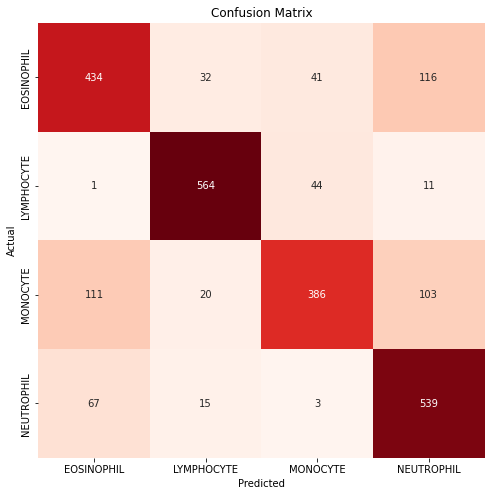

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.71      0.70      0.70       623
  LYMPHOCYTE       0.89      0.91      0.90       620
    MONOCYTE       0.81      0.62      0.71       620
  NEUTROPHIL       0.70      0.86      0.77       624

    accuracy                           0.77      2487
   macro avg       0.78      0.77      0.77      2487
weighted avg       0.78      0.77      0.77      2487



In [17]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

## ResNet50 with 2 epochs

In [18]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=2,validation_data=validationGenerator)

Epoch 1/2
265/265 [==============================] - 726s 3s/step - loss: 0.1059 - accuracy: 0.9642 - val_loss: 0.1173 - val_accuracy: 0.9671
Epoch 2/2
265/265 [==============================] - 726s 3s/step - loss: 0.0582 - accuracy: 0.9804 - val_loss: 0.0673 - val_accuracy: 0.9785


Test Accuracy: 73.341 %


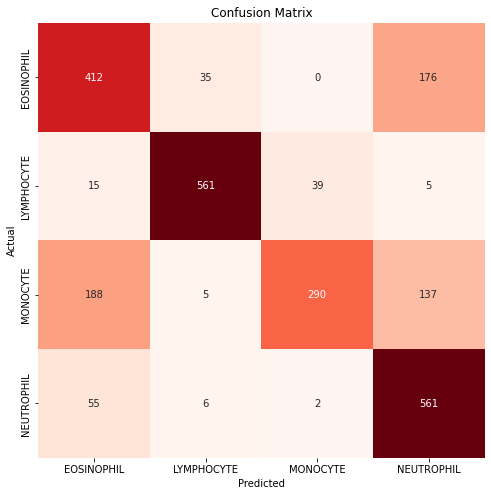

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.61      0.66      0.64       623
  LYMPHOCYTE       0.92      0.90      0.91       620
    MONOCYTE       0.88      0.47      0.61       620
  NEUTROPHIL       0.64      0.90      0.75       624

    accuracy                           0.73      2487
   macro avg       0.76      0.73      0.73      2487
weighted avg       0.76      0.73      0.73      2487



In [19]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

## ResNet50 with 3 epochs

In [20]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=3,validation_data=validationGenerator)

Epoch 1/3
265/265 [==============================] - 720s 3s/step - loss: 0.0517 - accuracy: 0.9831 - val_loss: 0.0319 - val_accuracy: 0.9920
Epoch 2/3
265/265 [==============================] - 712s 3s/step - loss: 0.0133 - accuracy: 0.9952 - val_loss: 0.0902 - val_accuracy: 0.9752
Epoch 3/3
265/265 [==============================] - 711s 3s/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.0253 - val_accuracy: 0.9926


Test Accuracy: 77.121 %


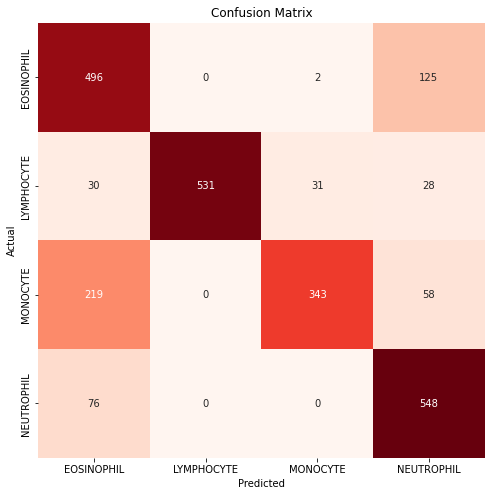

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.60      0.80      0.69       623
  LYMPHOCYTE       1.00      0.86      0.92       620
    MONOCYTE       0.91      0.55      0.69       620
  NEUTROPHIL       0.72      0.88      0.79       624

    accuracy                           0.77      2487
   macro avg       0.81      0.77      0.77      2487
weighted avg       0.81      0.77      0.77      2487



In [21]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

## ResNet50 with original Images

In [22]:
base_model = ResNet50(include_top=False,weights="imagenet")
for layer in base_model.layers[:140]:
    layer.trainable = False

In [23]:
model = keras.Sequential()

model.add(layers.Input(shape=(240,320,3)))
model.add(layers.Lambda(keras.applications.resnet50.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4,activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 240, 320, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 14,986,244
Non-trainable params: 8,609,664
_________________________________________________________________


In [24]:
testGen = ImageDataGenerator()
trainGen = ImageDataGenerator(validation_split=0.15,vertical_flip=True,horizontal_flip=True,rotation_range=0.2)
trainGenerator = trainGen.flow_from_directory(train_dataset_path,subset="training",target_size=(240,320))
validationGenerator = trainGen.flow_from_directory(train_dataset_path,subset="validation",target_size=(240,320))
testGenerator = testGen.flow_from_directory( test_dataset_path,target_size=(240,320),shuffle=False) 

Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


## ResNet50 with 1 epochs

In [25]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=1,validation_data=validationGenerator)

265/265 [==============================] - 1319s 5s/step - loss: 0.2231 - accuracy: 0.9210 - val_loss: 0.0683 - val_accuracy: 0.9765


Test Accuracy: 85.404 %


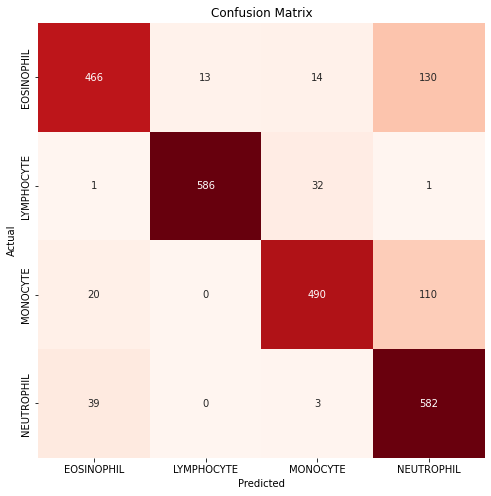

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.89      0.75      0.81       623
  LYMPHOCYTE       0.98      0.95      0.96       620
    MONOCYTE       0.91      0.79      0.85       620
  NEUTROPHIL       0.71      0.93      0.80       624

    accuracy                           0.85      2487
   macro avg       0.87      0.85      0.86      2487
weighted avg       0.87      0.85      0.86      2487



In [26]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

## ResNet50 with 2 epochs

In [27]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=2,validation_data=validationGenerator)

Epoch 1/2
265/265 [==============================] - 1313s 5s/step - loss: 0.0760 - accuracy: 0.9759 - val_loss: 0.1296 - val_accuracy: 0.9624
Epoch 2/2
265/265 [==============================] - 1316s 5s/step - loss: 0.0308 - accuracy: 0.9909 - val_loss: 0.0099 - val_accuracy: 0.9966


Test Accuracy: 84.801 %


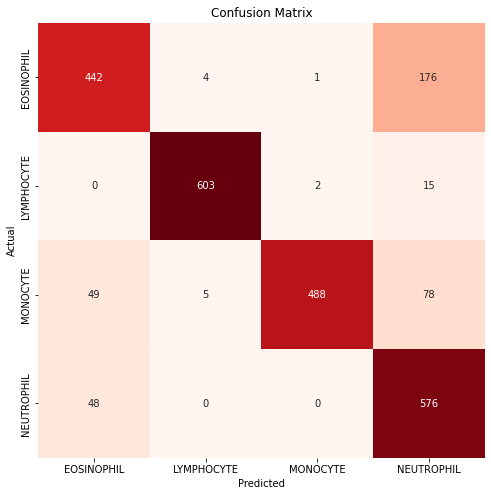

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.82      0.71      0.76       623
  LYMPHOCYTE       0.99      0.97      0.98       620
    MONOCYTE       0.99      0.79      0.88       620
  NEUTROPHIL       0.68      0.92      0.78       624

    accuracy                           0.85      2487
   macro avg       0.87      0.85      0.85      2487
weighted avg       0.87      0.85      0.85      2487



In [28]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)

## ResNet50 with 3 epochs

In [29]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit_generator(trainGenerator,epochs=3,validation_data=validationGenerator)

Epoch 1/3
265/265 [==============================] - 1320s 5s/step - loss: 0.0338 - accuracy: 0.9885 - val_loss: 0.0902 - val_accuracy: 0.9759
Epoch 2/3
265/265 [==============================] - 1316s 5s/step - loss: 0.0180 - accuracy: 0.9952 - val_loss: 0.0061 - val_accuracy: 0.9973
Epoch 3/3
265/265 [==============================] - 1320s 5s/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0071 - val_accuracy: 0.9980


Test Accuracy: 85.082 %


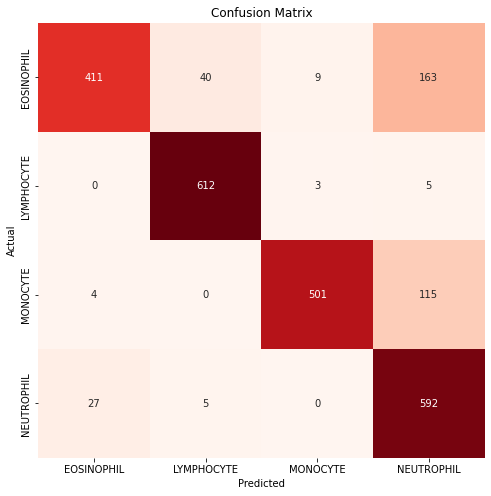

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.66      0.77       623
  LYMPHOCYTE       0.93      0.99      0.96       620
    MONOCYTE       0.98      0.81      0.88       620
  NEUTROPHIL       0.68      0.95      0.79       624

    accuracy                           0.85      2487
   macro avg       0.88      0.85      0.85      2487
weighted avg       0.88      0.85      0.85      2487



In [30]:
CLASS_NAMES = list(trainGenerator.class_indices.keys())
predictions = np.argmax(model.predict(testGenerator), axis=1)

acc = accuracy_score(testGenerator.labels, predictions)
cm = tf.math.confusion_matrix(testGenerator.labels, predictions)
clr = classification_report(testGenerator.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f} %".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks=np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-----------------------------\n", clr)